In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout, Flatten
from tensorflow.keras.applications.densenet import DenseNet169
%matplotlib inline

In [ ]:
!ls ../input/data/

In [ ]:
# images_001 range(00000001_000.png to 00001335_006.png)
# images_002 range(00001336_000.png to 00003923_013.png)
# images_003 range(00003923_014.png to 00006585_006.png)
# images_004 range(00006585_007.png to 00009232_003.png)
# images_005 range(00009232_004.png to 00011558_007.png)
# images_006 range(00011558_008.png to 00013774_025.png)
# images_007 range(00013774_026.png to 00016051_009.png)
# images_008 range(00016051_010.png to 00018387_034.png)
# images_009 range(00018387_035.png to 00020945_049.png)
# images_010 range(00020945_050.png to 00024717_000.png)
# images_011 range(00024718_000.png to 00030805_000.png)
# images_012 range()

# create a dictionary of all the subdirectories
images_dic = {
              'images_001':[],
              'images_002':[],
              'images_003':[],
              'images_004':[],
              'images_005':[],
              'images_006':[],
              'images_007':[],
              'images_008':[],
              'images_009':[],
              'images_010':[],
              'images_011':[],
              'images_012':[]
             }

for subdir in images_dic.keys():
    for path, subdirs, files in os.walk(f'../input/data/{subdir}/images/'):
        for filename in files:
            images_dic[subdir].append(filename)
            


In [ ]:
# view that all the keys and images were listed
images_dic_lengths = [(key, len(images_dic[key])) for key in images_dic.keys()]
images_dic_lengths

## Import the Meta Data into Dataframes

In [ ]:
#import the meta-data for the images
data_entry_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
data_entry_df.drop(columns=['Unnamed: 11'], inplace=True)
data_entry_df.head()

In [ ]:
# training data
training_data = []
with open('../input/data/train_val_list.txt') as mytext:
    for line in mytext:
        training_data.append(line.rstrip())

In [ ]:
# test data
testing_data = []
with open('../input/data/test_list.txt') as mytext:
    for line in mytext:
        testing_data.append(line.rstrip())

In [ ]:
import matplotlib.image as mpimage

ex1_data = mpimage.imread('../input/data/images_001/images/00000001_000.png')
imgplot = plt.imshow(ex1_data, cmap='gray')


In [ ]:
# create a function that returns the full image path
def full_img_path(file_name, img_dic=images_dic):
    '''
        The function takes in the .png file name and the dictionary of all images
        Then finds the subdirectory name with that images in its list
        Returns the full path in a string format
    '''
    try:
        for key in img_dic.keys():
            if file_name in img_dic[key]:
                full_path = f'../input/data/{key}/images/{file_name}'
                return full_path
    except:
        return None

In [ ]:
# create a new dataframe for the image path and get the full path and store it
image_path_df = data_entry_df[['Image Index']]
image_path_df['path'] = image_path_df['Image Index'].apply(full_img_path)
image_path_df.head()

In [ ]:
# to for easier access later
# image_path_df.to_csv('image_path.csv')

In [ ]:
#saved_df = pd.read_csv('image_path.csv', index_col=[0])
#saved_df.head()

In [ ]:
image_path_df.isna().sum()


### Combine the image_path_df with the data_entry_df

In [ ]:
data_entry_df = pd.merge(data_entry_df, image_path_df, how="inner", on='Image Index')
data_entry_df.head()

## View an X-ray Image

In [ ]:
# create a function to load images
def load_image(file_name):
    '''
        The function takes in .png file name
        Then checks all the image directories for the file
        Returns the image data as an matrix of pixel values
    '''
    for n1 in range(2):
        for n2 in range(1, 10):
            image_dir = f'../input/data/images_0{n1}{n2}/images/'
            if os.path.isfile(image_dir+file_name):
                image_data = mpimage.imread(image_dir+file_name)
    return image_data

In [ ]:
# view one of the xrays
image_1 = load_image(data_entry_df.loc[0, 'Image Index'])
plt.imshow(image_1, cmap='gray')

## Create dataframes for testing and training

In [ ]:
train_df = data_entry_df[data_entry_df['Image Index'].isin(training_data)]
test_df = data_entry_df[data_entry_df['Image Index'].isin(testing_data)]

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
# split the finding labels 
train_labels = train_df['Finding Labels'].str.split('|')
test_labels = test_df['Finding Labels'].str.split('|')

In [ ]:
train_df['Finding Labels'] = train_labels
train_df.head()

In [ ]:
test_df['Finding Labels'] = test_labels
test_df.head()

In [ ]:
diseases = []
for disease in train_labels:
    for val in range(len(disease)):
        if disease[val] not in diseases:
            diseases.append(disease[val])

In [ ]:
diseases

## View the Distribution of Diseases

In [ ]:
# create a function for getting the disease counts and return dataframe
def disease_counts(diseases_list, df):
    
    diseases_dict = {}
    count = 0

    for disease in diseases_list:
        for idx, row in df.iterrows():
            if disease in df.loc[idx, 'Finding Labels']:
                count += 1 
        diseases_dict[disease] = count
        count = 0
        
    diseases_df = pd.DataFrame.from_dict(diseases_dict, orient='index', columns=['Count'])
    
    return diseases_df

In [ ]:
# get the disease counts for the training df
train_disease_df = disease_counts(diseases, train_df)
train_disease_df

In [ ]:
# Plot the distribution of diseases
sns.set(rc={"figure.figsize":(8, 8)}) #width=8, #height=8
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=train_disease_df['Count'], y=train_disease_df.index)

In [ ]:
# view the values sorted
train_disease_df.sort_values(by=['Count'], ascending=True)

### Analysis of the Training Set Disease Distribution:

There is a large difference between the most frequent diseases and the least frequent diseases. Hernia has almost two orders of magnitude more that the least frequent disease Cardiomegaly.

Since this is an image classification model, in which training is resource expense, the least frequent disease will roughly set the count for all other diseases, though pneumonia will be expected to be present in roughly half of the training set.

In [ ]:
# view the distribution of diseases in the testing dataset
test_disease_df = disease_counts(diseases, test_df)
test_disease_df.sort_values(by=['Count'], ascending=True)

In [ ]:
# Plot the distribution of diseases
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=test_disease_df['Count'], y=test_disease_df.index)

### Analysis of the Testing Disease Distribution:
The least frequent diseases are orders of magnitude less than the most frequent diseases. Since the test set should a representation of what happens in the real world, this proportion should be kept for the test set since it looks like what was found from the NIH.

The test size is large for an image classifier deep learning model, therefor using randomized selection with binning could create a good way of reducing the test size.

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df.head(10)

## Create a Pneumonia Column for Classification

In [ ]:
train_df['Pneumonia'] = [0]*train_df.shape[0]

In [ ]:
# iterate through the rows and assign 1 to Pneumonia if it is present in Finding Labels


for idx, row in train_df.iterrows():
    if 'Pneumonia' in row['Finding Labels']:
        train_df.loc[idx, 'Pneumonia'] = 1

In [ ]:
train_df['Pneumonia'].value_counts()

### The Pneumonia X-ray images are significantly under represented

This will likely cause the model to be unable to learn pneumonia due to the skewed dataset. In order to increase their prevalence for training this binary classifier, the number of non-pneumonia images will be decreased by 10x. Since this is an image classifier using a pre-trained model, the number of images may need to only be around 1000 images total with a good proportion of them being positive for pneumonia.

In [ ]:
train_pneumonia = train_df[train_df['Pneumonia'] == 1]

train_pneumonia['Pneumonia'].value_counts()

## One-Hot Encode the Diseases for Training

In [ ]:
# one hot encode columns for diseases
trn_disease_df = pd.DataFrame(columns=diseases)
trn_disease_df

In [ ]:
for idx, row in train_df.iterrows():
    for disease in row['Finding Labels']:
        trn_disease_df.loc[idx, disease] = 1

In [ ]:
trn_disease_df = trn_disease_df.fillna(value=0)
trn_disease_df.head()

In [ ]:
# view the values sorted
train_disease_df.sort_values(by=['Count'], ascending=True)

## Narrow Down the Images
Start by taking roughly 100 images of each non-pneumonia classification and then and equal amount of pneumonia classification

There are 14 non-pneumonia classifications and at 100 images per class that equals 1400 images with non-pneumonia, and then combine with 1400 images with pneumonia.

In [ ]:
# create a function for returning a dataframe with a certain disease and sample size
def sample_no_pneumonia(df, disease, sample_size=100):
    boolean_condition = (df[disease] == 1)&(df['Pneumonia'] == 0)
    return df[boolean_condition].sample(n=sample_size)

In [ ]:
select_train_df = sample_no_pneumonia(trn_disease_df, diseases[0], sample_size=100)

# create a variable to adjust the sample size as the count varies among iterations
adjusted_size = 100

for i in range(1,len(diseases)):
    # only run this for non-pneumonia diseases
    if diseases[i] != 'Pneumonia':
        disease_df = sample_no_pneumonia(trn_disease_df, diseases[i], sample_size = adjusted_size)
        select_train_df = pd.concat([select_train_df, disease_df], axis=0)
    
        if i < (len(diseases) - 1):
            # look at the count for the next disease
            next_dis_count = select_train_df.sum()[diseases[i+1]]
    
            # adjust the sample size towards 100
            adjusted_size = 100 - next_dis_count

In [ ]:
# view the counts for each finding
select_train_df.sum()

In [ ]:
# view the total number of images in this selected dataframe
select_train_df.shape[0]

### Analysis of the new training dataframe
Here there is a nice distribution of the diseases and should provide plenty of examples for the model to learn different varieties of non-pneumonia.

**The total number of images for training that do not have pneumonia are 1033.**

**There are only 876 pneumonia images in the training dataset. All will be included**

- Next step is to add in 876 pneumonia images, randomly sampled with co-diseases

## Select Pneumonia Training Data

In [ ]:
# create a function for returning a dataframe with a certain disease and sample size
def sample_pneumonia(df, disease, sample_size=876):
    return df[df['Pneumonia'] == 1].sample(n=sample_size)

In [ ]:
pneumonia_sample_df = sample_pneumonia(trn_disease_df, 'Pneumonia')
select_train_df = pd.concat([select_train_df, pneumonia_sample_df], axis=0)
select_train_df.sum()

### Balanced Training Data 

There is now a large percentage of Pneumonia images for training which should allow the model to learn to identify Pneunomia and not learn to classify most images as 0 since in a highly imbalanced dataset that would lead to high accuracy but perform terribly for actually predicting pneumonia.

## Index the Training Data for Semi-Balanced Classes

In [ ]:
filter_index = select_train_df.index

In [ ]:
filter_index[:10]

In [ ]:
final_train_df = train_df.iloc[filter_index, :]
print('Shape of the training dataframe:', final_train_df.shape)
print('Count of Pneumonia images in training df:', final_train_df['Pneumonia'].sum())

In [ ]:
final_train_df.head()

In [ ]:
final_train_disease_df.tail()

In [ ]:
final_train_disease_df = disease_counts(diseases, final_train_df)
# Plot the distribution of diseases for training data
sns.set(rc={"figure.figsize":(8, 8)}) #width=8, #height=8
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=final_train_disease_df['Count'], y=final_train_disease_df.index)

### Analysis of Training Dataframe Distribution

- The training data has been narrowed down to 1942 images
- The training data is fairly evenly split between Pneumonia and non-Pneumonia
- There is a fairly equal distribution of non-Pneumonia images by Finding

By performing this data selection, it ensures that there are enough images of Pneumonia for the model to learn the characteristics of a Pneumonia X-ray, while also seeing enough non-Pneumonia X-rays to ensure that the expect co-diseases do not get labeled frequently as False Positives, as well, the variety should prevent overfitting to the training data. 

## Create a Pneumonia Column for the Test Data

In [ ]:
test_df['Pneumonia'] = [0]*test_df.shape[0]

In [ ]:
# iterate through the rows and assign 1 if Pneumonia is present
for idx, row in test_df.iterrows():
    if 'Pneumonia' in test_df.loc[idx, 'Finding Labels']:
        test_df.loc[idx, 'Pneumonia'] = 1

## Narrow Down the Test Data Size

**Over 25500 images** for testing is significantly **too many.** But because there is such a small proportion of Pneumonia cases, it will be important to get a significant amount of training data to get a sense of how well the model actually classifies pneumonia. This will be **narrowed down to a 1000 images** with the distribution being similar to the raw dataset given, since that is similar to the distribution of X-rays seen normally by the hospital. This test datset is as large as the training set.

In [ ]:
# sample 1000 random rows from the test_df
test_df = test_df.sample(n=1000, axis=0)
test_df['Pneumonia'].value_counts()

## Image Generators and Augmentation

In [ ]:
def create_splits(df):
    ''' 
        The input is a dataframe
        The function will have two outputs a training dataframe and a validation dataframe
        This function will focus on splitting with a balanced set of pneumonia and non-pneumonia for the training set
        Validation dataset will not have any requirements for balanced data
    '''
    
    # create a split of pneumonia and non-pneumonia
    pneum = df[df['Pneumonia'] == 1]
    no_pneum = df[df['Pneumonia'] == 0]
    
    
    # get 80% training set with 50% being pneumonia positive, thus take 80% of the pneumonia positive data

    # shuffle the pneum data for random selection
    shuffled_pneum = pneum.sample(frac=1).reset_index(drop=True)

    # take the top 80% of the shuffled dataframe for training positive results
    index = round(len(shuffled_pneum)*0.8)
    train_pneum = shuffled_pneum[:index]

    # take the rest of the dataframe for the testing data
    val_pneum = shuffled_pneum[index:]

    # shuffle the no_pneum data for random selection
    shuffled_no_pneum = no_pneum.sample(frac=1).reset_index(drop=True)

    # take the top amount equal to the length of the pneum dataframe
    index = len(train_pneum)
    train_no_pneum = shuffled_no_pneum[:index]

    # test that the length of pneumonia and no pneumonia are equal
    assert len(train_pneum) == len(train_no_pneum)

    # concatenate the two dataframes into one training dataframe
    train_df = pd.concat([train_pneum, train_no_pneum], axis=0)

    # shuffle the train_df to get randomness for positive and negative pneumonia
    train_df = train_df.sample(frac=1).reset_index(drop=True)


    # create a testing dataset of no pneum with equal number to pneumonia
    val_no_pneum = shuffled_no_pneum[-(len(val_pneum)):]



    # concatenate the two testing dataframes
    val_df = pd.concat([val_pneum, val_no_pneum])

    
    
    return train_df, val_df

In [ ]:
# create the final training df (80%) and validation df (20%)
final_train_df, final_val_df = create_splits(final_train_df)

In [ ]:
print('Train dataset count:', final_train_df.shape[0])
print('Validation dataset count:', final_val_df.shape[0])

In [ ]:
print('Validation Counts:\n', final_val_df['Pneumonia'].value_counts())
print('\nTrain Counts:\n', final_train_df['Pneumonia'].value_counts())

#### Evenly split with Pneumonia and Non-Pneumonia X-rays images for training and validation

In [ ]:
# replace the 0's for No_Pneumonia and 1's for Pneumonia for the image generators
final_train_df['Pneumonia'] = final_train_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
final_val_df['Pneumonia'] = final_val_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
test_df['Pneumonia'] = test_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])

In [ ]:
test_df['Pneumonia'].value_counts()

#### Test data is more similar to real-world distribution of pneumonia

## Create Image Generators

In [ ]:
# first round do not use any augmentation
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0,
                                       width_shift_range = 0,
                                       rotation_range = 0,
                                       shear_range = 0, zoom_range = 0)



In [ ]:
# most common image size
IMAGE_SIZE=(224,224)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe = final_train_df, 
                                                    directory = None, 
                                                    x_col = 'path',
                                                    y_col = 'Pneumonia',
                                                    class_mode = 'binary',
                                                    target_size = IMAGE_SIZE, 
                                                    batch_size = 16)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)

In [ ]:
val_generator = val_datagen.flow_from_dataframe(
                                                dataframe = final_val_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size = 16)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
                                                dataframe = test_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size=100 
                                                )

## View Labeled X-ray Images

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build Pre-Trained Model

In [ ]:
def load_pretrained_model(verbose=False):
    
    input_shape = (224, 224, 3)
    input_layer = Input(shape = (224, 224, 3))
    
    # baseline densenet model
    densenet_base = DenseNet169(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )
    
    

    # freeze the layers of the base model
    for layer in densenet_base.layers:
        layer.trainable = False

    
    if verbose:
        # print the layers
        print('DenseNet169 Layers:')
        for layer in densenet_base.layers:
            print(layer.name, 'Trainable:', layer.trainable)
    
    return densenet_base

In [ ]:
densenet_base = load_pretrained_model()

In [ ]:
# create the one trainable hidden layer and the output layer with one node using sigmoid activation
densenet_model = Sequential()
densenet_model.add(densenet_base)
densenet_model.add(Flatten())
densenet_model.add(Dropout(0.1))
densenet_model.add(Dense(units=1024, activation='relu'))
densenet_model.add(Dense(activation='sigmoid', units = 1))

## Run the Model

In [ ]:
optm = Adam(learning_rate=0.0001)
densenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['binary_accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#checkpoint = ModelCheckpoint('./densenet169_baseline.h5', 
#                              monitor= 'val_loss', 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= 'min', 
#                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [early]

## Training the Model

In [ ]:


valX, valY = val_generator.next()

history = densenet_model.fit(train_generator, 
                          validation_data = (valX, valY), 
                          epochs = 45, 
                          callbacks = callbacks_list)

In [ ]:
print(history.history.keys())

In [ ]:
# plot the accuracy of the model
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Each Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# plot the loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Each Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test the Model

In [ ]:
X_test, y_test = test_generator.next()

In [ ]:
# count how many 1's
np.sum(y_test)

In [ ]:
X_test.shape

In [ ]:
y_preds = densenet_model.predict(X_test, batch_size = 1000, verbose = True)

In [ ]:
y_preds.shape

In [155]:
from sklearn.metrics import classification_report

## Analysis of Semi-Balanced Data with One Hidden Layer
**The validation loss did not seem to improve over the epochs.**

This implies that the model is overfitting to the training data and that may be because the balancing of the diseases it made it learn rare diseases too much and thus needs to improve bias for more generalization.

**Next Step**
- Try training and validation data only balanced on Pneumonia vs No Pneumonia

## Transfer Model Trained on Data Balanced only on Pneumonia

In [ ]:
train_df.head()

In [ ]:
train_df['Pneumonia'].value_counts()

In [ ]:
# get the pneumonia data
pneum_train_df = train_df[train_df['Pneumonia'] == 1]

# create a dataframe of 1% of the no pneumonia data
no_pneum_train_df = train_df[train_df['Pneumonia'] == 0].sample(frac=0.01).reset_index(drop=True)

In [ ]:
pneum_train_df.shape, no_pneum_train_df.shape

In [ ]:
final_train_df = pd.concat([pneum_train_df, no_pneum_train_df], axis=0)
final_train_df['Pneumonia'].value_counts()

In [149]:
# create the final training df (80%) and validation df (20%)
final_train_df, final_val_df = create_splits(final_train_df)

final_train_df['Pneumonia'].value_counts(), final_val_df['Pneumonia'].value_counts()

(1    561
 0    561
 Name: Pneumonia, dtype: int64,
 1    140
 0    140
 Name: Pneumonia, dtype: int64)

### This is a balanced training dataset. Now time to create the image generators

### Create a Image Generator Function

In [161]:
def image_gens_no_aug(final_train_df, final_val_df, test_df, image_size=(224, 224)):

    # replace the 0's for No_Pneumonia and 1's for Pneumonia for the image generators
    final_train_df['Pneumonia'] = final_train_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
    final_val_df['Pneumonia'] = final_val_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
    test_df['Pneumonia'] = test_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])

    # first round do not use any augmentation
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0,
                                       width_shift_range = 0,
                                       rotation_range = 0,
                                       shear_range = 0, zoom_range = 0)



    train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe = final_train_df, 
                                                    directory = None, 
                                                    x_col = 'path',
                                                    y_col = 'Pneumonia',
                                                    class_mode = 'binary',
                                                    target_size = image_size, 
                                                    batch_size = 16)
    
    val_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)


    val_generator = val_datagen.flow_from_dataframe(
                                                dataframe = final_val_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = image_size,
                                                batch_size = 16)

    test_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)


    test_generator = test_datagen.flow_from_dataframe(
                                                dataframe = test_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = image_size,
                                                batch_size=200 
                                                )


    return train_generator, val_generator, test_generator

In [162]:
train_generator, val_generator, test_generator = image_gens_no_aug(final_train_df, final_val_df, test_df)

Found 1122 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [152]:
densenet_base = load_pretrained_model()

# create the one trainable hidden layer and the output layer with one node using sigmoid activation
densenet_model = Sequential()
densenet_model.add(densenet_base)
densenet_model.add(Flatten())
densenet_model.add(Dropout(0.1))
densenet_model.add(Dense(units=1024, activation='relu'))
densenet_model.add(Dense(activation='sigmoid', units = 1))

optm = Adam(learning_rate=0.0001)
densenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['binary_accuracy'])

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [early]

valX, valY = val_generator.next()

history = densenet_model.fit(train_generator, 
                          validation_data = (valX, valY), 
                          epochs = 45, 
                          callbacks = callbacks_list)

Epoch 1/45
71/71 [==============================] - 35s 388ms/step - loss: 1.5067 - binary_accuracy: 0.5374 - val_loss: 0.4163 - val_binary_accuracy: 0.8125
Epoch 2/45
71/71 [==============================] - 18s 254ms/step - loss: 0.5627 - binary_accuracy: 0.6979 - val_loss: 0.6490 - val_binary_accuracy: 0.6250
Epoch 3/45
71/71 [==============================] - 19s 263ms/step - loss: 0.4504 - binary_accuracy: 0.7932 - val_loss: 0.8395 - val_binary_accuracy: 0.5000
Epoch 4/45
71/71 [==============================] - 18s 257ms/step - loss: 0.3505 - binary_accuracy: 0.8467 - val_loss: 0.4896 - val_binary_accuracy: 0.7500
Epoch 5/45
71/71 [==============================] - 19s 272ms/step - loss: 0.2508 - binary_accuracy: 0.9127 - val_loss: 0.5500 - val_binary_accuracy: 0.7500
Epoch 6/45
71/71 [==============================] - 20s 285ms/step - loss: 0.1998 - binary_accuracy: 0.9385 - val_loss: 0.4503 - val_binary_accuracy: 0.8750
Epoch 7/45
71/71 [==============================] - 19s 27

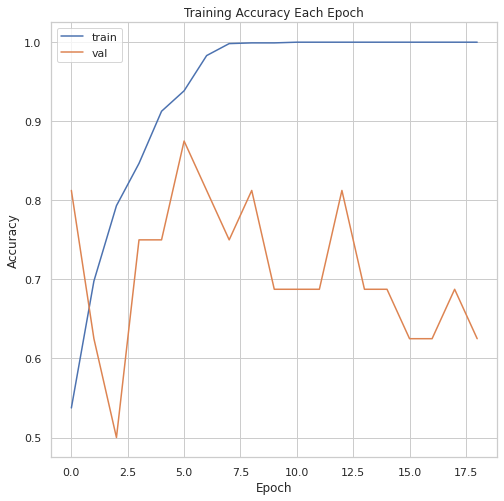

In [153]:
# plot the accuracy of the model
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Each Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

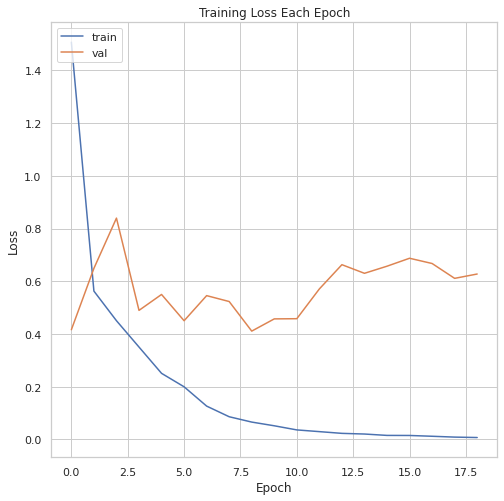

In [154]:
# plot the loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Each Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
X_test, y_test = test_generator.next()
y_preds = densenet_model.predict(X_test, batch_size = 200, verbose = True)

y_preds = [1 if pred > 0.5 else 0 for pred in y_preds]


print(classification_report(y_test, y_preds))

1/1 [==============================] - 6s 6s/step
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61       199
         1.0       0.01      1.00      0.02         1

    accuracy                           0.44       200
   macro avg       0.50      0.72      0.31       200
weighted avg       1.00      0.44      0.61       200



## Create Summary Statistics for Model Analysis

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

# build a function for AUC 
def plot_auc(t_y, p_y):
    
    fpr, tpr, threshold = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    return plt.show()


# create a function for accuracy
def accuracy(t_y, p_y, threshold=0.5):
    '''
        (True Negatives + True Positives) / All Values
    '''
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] >= threshold:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] < threshold:
            tn += 1
    
        numerator = tn + tp
        denominator = len(t_y)
    
    return numerator/denominator
    


# build a function for precision
def precision(t_y, p_y, threshold=0.5):
    '''
       True Positives / (True Positives + False Positives)
    '''
    
    # true positives
    tp = 0
    # false positives
    fp = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] >= 0.50:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] < 0.50:
            fp += 1
    
    return tp / (tp+fp)



# build a function for sensitivity
def sensitivity(t_y, p_y, threshold=0.5):
    '''
        True Positives / (True Positives + False Negatives)
    '''
    # true positives
    tp = 0
    # false negatives
    fn = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] >= 0.50:
            tp += 1
        # find the false negatives
        elif t_y[i]==1.0 and p_y[i] < 0.50:
            fn += 1
    
    return tp / (tp+fn)



# build a function for F1 score
def f1_score(sens, prec):
    '''
       F1 score is  2 * (Sensitivity * Precision) / (Sensitivity + Precision)
    '''
    
    return 2 * ((sens*prec) / (sens+prec))
    
    
    
# get the metrics for all scores:
def summary_metrics(t_y, p_y, threshold=0.5):
    acc = accuracy(t_y, p_y, threshold=threshold)
    print('Accuracy:', acc)    
    prec = precision(t_y, p_y, threshold=threshold)
    print('Precision:', prec)
    sens = sensitivity(t_y, p_y, threshold=threshold)
    print('Sensitivity:', sens)
    f1 = f1_score(sens, prec)
    print('F1 Score:', f1)
    
    
    
    
# plot the history of the loss function
def plot_loss_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt.show()


# plot the history of the accuracy
def plot_accuracy_history(history):
    
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    return plt.show()


def plot_prec_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision Recall Curve')
    
    return plt.show()



def pred_class(p_y, threshold):
    '''
        Takes in probability array and converts to 0 or 1 based on threshold
    '''
    
    preds = list(map(lambda x: 0 if x < threshold else 1, p_y))
    
    return np.array(preds)
    

def plot_metrics(t_y, p_y):
    '''
        Create a plot of Accuracy, Precision, Sensitivity, and F1
        vs the threshold on a range of 0.4 to 0.6
    '''
    
    
    # create the threshold range
    thresh_list = list(range(40, 62, 2))
    thresholds = [(x/100) for x in thresh_list]
    
    # create a list for each metric
    acc_list, sens_list, prec_list, f1_list = [], [], [], []
    
    for num in thresholds:
        preds = pred_class(p_y, threshold=num)
        # calculate the metrics and append to list
        acc_list.append(accuracy(t_y, preds))
        prec_list.append(precision(t_y, preds))
        sens_list.append(sensitivity(t_y, preds))
        #f1_list.append(f1_score(t_y, preds))
        
    plt.plot(thresholds, acc_list, color='red', label='Accuracy')
    plt.plot(thresholds, prec_list, color='blue', label='Precision')
    plt.plot(thresholds, sens_list, color='black', label='Sensitivity')
    #plt.plot(thresholds, f1_list, color='green', label='F1')
    plt.xlabel("Threshold")
    plt.ylabel("Performance Metric")
    plt.legend()
    plt.title('Summary of Threshold and Statistic Metrics')
    
    return plt.show()

In [ ]:
# create a function to return all the important statistical plots and values

def model_performance_stats(true_y, pred_y, threshold=0.5):
    summary_metrics(true_y, pred_y, threshold=threshold)
    plot_auc(true_y, pred_y)
    plot_metrics(true_y, pred_y)

In [ ]:
model_performance_stats(y_test, y_preds.reshape(-1))

## Hyperparameter Optimization

In [ ]:
def build_transfer_model(no_layers=1, dropout=0.1, start_units=1024, lr=0.001, optm='Adadelta'):
    
    # load the Densenet Transfer model
    densenet_base = load_pretrained_model()
    
    # create the base layers
    densenet_model = Sequential()
    densenet_model.add(densenet_base)
    densenet_model.add(Flatten())
    
    # add hidden layers with decreasing nodes per layer
    if no_layers > 0:
        for layer in range(1,no_layers):
            densenet_model.add(Dropout(dropout))
            densenet_model.add(Dense(units=(start_units / layer), activation='relu'))
            
    # output layer
    densenet_model.add(Dense(activation='sigmoid', units=1))
    
    if optm == 'Adam':
        opt = Adam(learning_rate=lr)
        densenet_model.compile(
                        loss='binary_crossentropy',
                        optimizer=opt,
                        metrics=['accuracy'])
        
    elif optm == 'RMSprop':
        opt = RMSprop(learning_rate=lr)
        densenet_model.compile(
                        loss='binary_crossentropy',
                        optimizer=opt,
                        metrics=['accuracy'])
        
    elif optm == 'Adadelta':
        opt = Adadelta(learning_rate=lr)
        densenet_model.compile(
                            loss='binary_crossentropy',
                            optimizer=opt,
                            metrics=['accuracy'])
        
    early_stop = EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            verbose=1,
                            mode='min')
    
    model_save = ModelCheckpoint('./densenet169_baseline.h5',
                            save_best_only = True,
                            save_weights_only = True,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)
    
    
    callbacks_list=[model_save, early_stop]

    
    return densenet_model, callbacks_list

In [ ]:
def create_img_datagens(train_df, val_df, test_df, ht_shift=0,wdth_shift=0, rotation=0, shear=0, zoom=0, batch_size=16):
    
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = ht_shift,
                                       width_shift_range = wdth_shift,
                                       rotation_range = rotation,
                                       shear_range = shear, zoom_range = zoom)
    
    # most common image size
    IMAGE_SIZE=(224,224)

    train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe = train_df, 
                                                    directory = None, 
                                                    x_col = 'path',
                                                    y_col = 'Pneumonia',
                                                    class_mode = 'binary',
                                                    target_size = IMAGE_SIZE, 
                                                    batch_size = batch_size)
    
    val_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)
    
    val_generator = val_datagen.flow_from_dataframe(
                                                dataframe = val_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size = batch_size)
    
    test_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)
    
    test_generator = test_datagen.flow_from_dataframe(
                                                dataframe = test_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size=1000 # total number of testing samples
                                                )
    
    return train_generator, val_generator, test_generator

In [ ]:
# replace the 0's for No_Pneumonia and 1's for Pneumonia for the image generators
final_train_df['Pneumonia'] = final_train_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
final_val_df['Pneumonia'] = final_val_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
test_df['Pneumonia'] = test_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])

In [ ]:
for num in [2]:
    for lr in [0.01]:

        model, callbacks_list = build_transfer_model(no_layers=num, dropout=0.1, start_units=1024, lr=lr, optm='Adadelta')

        train_generator, val_generator, test_generator = create_img_datagens(final_train_df, final_val_df, test_df)

        valX, valY = val_generator.next()

        history = model.fit(train_generator, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)
        
        X_test, y_test = test_generator.next()
        
        model_performance_stats(y_test, y_preds)
        
        y_preds = model.predict(X_test, batch_size = 1000, verbose = True)

In [ ]:
# builtin keras save model code
#model_save_full_path = os.path.join(ROOT, 'saved_models', 'conv2d_version_1_acc_79_84')
#model.save(model_save_full_path)